# Runtime checking for CN

Some measurements coming from CN with `ooniprobe-react-os` have a very high measurement per minute rate, a bit unrealistic for web connectivity measurements.

We want to check if there's something different with this measurements comparing them with other measurements also from China

In [49]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from bokeh.plotting import figure, show

In [50]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [51]:
from clickhouse_driver import Client as Clickhouse
from uuid import uuid4
from pathlib import Path

def click_query(q, params=None):
    click = Clickhouse("localhost")
    return click.query_dataframe(q, params=params)

def click_query_fsn(q, params=None):
    click = Clickhouse("backend-fsn.ooni.org")
    return click.query_dataframe(q, params=params)

In [52]:
def get_explorer_url(e):
    return f'https://explorer.ooni.org/m/{e['measurement_uid']}'
def print_explorer_url(e):
    print(get_explorer_url(e))

# Measurements for ooniprobe-react-os

In [53]:
react_df = click_query_fsn(
    """
select test_runtime, software_name, probe_cc, probe_asn 
from fastpath
where software_name = 'ooniprobe-react-os' and measurement_start_time > '2025-01-01'
AND measurement_start_time < '2025-03-10'
    """
)

cn_df = click_query_fsn("""
select test_runtime, software_name, probe_cc, probe_asn 
from fastpath
where software_name <> 'ooniprobe-react-os' and probe_cc = 'CN' and measurement_start_time > '2025-01-01'
AND measurement_start_time < '2025-03-10'
""")

In [54]:
cn_df

,test_runtime,software_name,probe_cc,probe_asn
0,45.264584,ooniprobe-cli,CN,4812
1,16.632612,ooniprobe-cli,CN,4812
2,16.662729,ooniprobe-cli,CN,4812
3,2.095300,ooniprobe-cli,CN,4812
4,3.885004,ooniprobe-cli,CN,4812
...,...,...,...,...
299204,18.610882,ooniprobe-desktop-unattended,CN,132525
299205,51.042877,ooniprobe-desktop-unattended,CN,4837
299206,35.182690,ooniprobe-desktop-unattended,CN,132525
299207,35.775673,ooniprobe-desktop-unattended,CN,4837


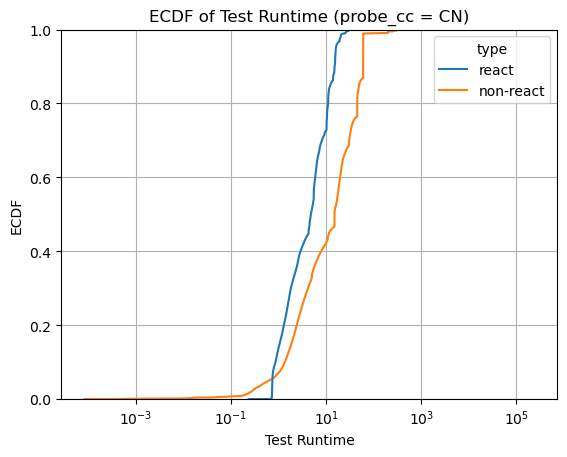

In [60]:
all_df = pd.concat([react_df, cn_df], ignore_index=True)
all_df['type'] = 'non-react'
all_df.loc[0:len(react_df), 'type'] = 'react'
all_df[['test_runtime', 'type']]

# Plot the ECDF using Seaborn
sns.ecdfplot(data=all_df, x='test_runtime', hue='type', log_scale=True)

# Styling and labels
plt.title('ECDF of Test Runtime (probe_cc = CN)')
plt.xlabel('Test Runtime')
plt.ylabel('ECDF')
plt.grid(True)

plt.savefig('figures/ecdf_test_runtime_react_os.png')
plt.show()

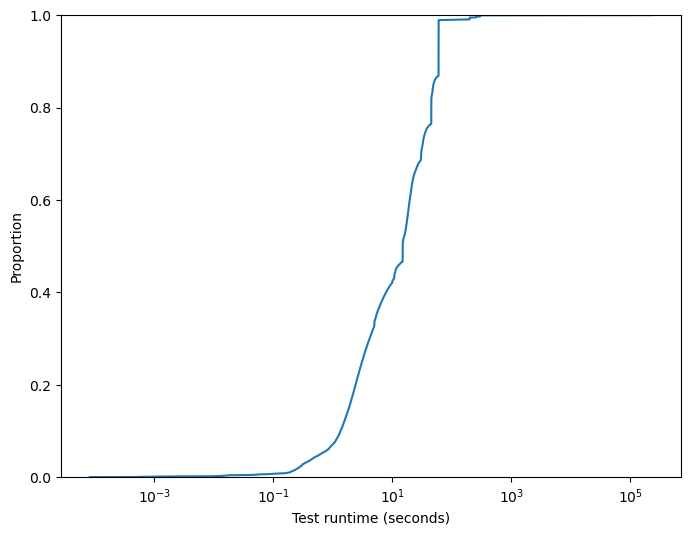

In [56]:
plt.figure(figsize=(8, 6))
sns.ecdfplot(cn_df['test_runtime'], log_scale = True)
plt.xlabel("Test runtime (seconds)")
plt.show()

<Axes: xlabel='test_runtime', ylabel='Count'>

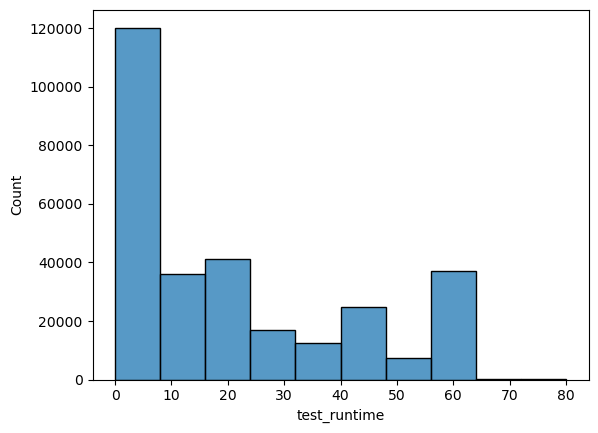

In [57]:
sns.histplot(cn_df[cn_df['test_runtime'] <= 80]['test_runtime'], bins = 10)

<Axes: xlabel='test_runtime', ylabel='Count'>

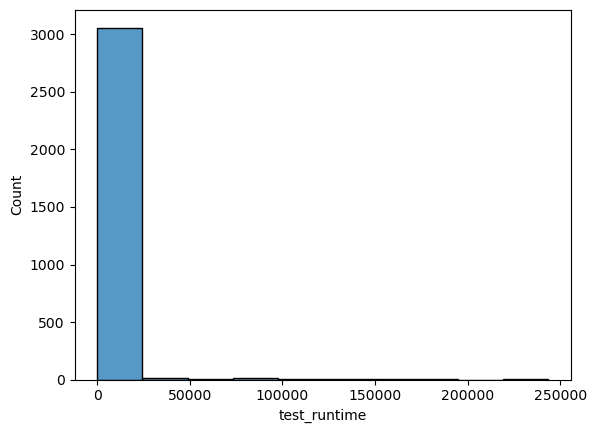

In [58]:
sns.histplot(cn_df[cn_df['test_runtime'] > 80]['test_runtime'], bins = 10)